In [3]:
using DataFrames
using Distances
using LinearAlgebra
using Makie
using MLBase
using MultivariateStats
using Plots
using RDatasets
using ScikitLearn
using Statistics
using StatsBase
using UMAP
using VegaDatasets
using XLSX

┌ Info: Precompiling VegaDatasets [0ae4a718-28b7-58ec-9efb-cded64d6d5b4]
└ @ Base loading.jl:1278
┌ Info: Precompiling XLSX [fdbf4ff8-1666-58a4-91e7-1b58723a45e0]
└ @ Base loading.jl:1278


In [10]:
C = DataFrame(VegaDatasets.dataset("cars"))
C[1:5, :]

,Name,Miles_per_Gallon,Cylinders,Displacement,Horsepower
,String,Float64?,Int64,Float64,Int64?
1,chevrolet chevelle malibu,18.0,8,307.0,130
2,buick skylark 320,15.0,8,350.0,165
3,plymouth satellite,18.0,8,318.0,150
4,amc rebel sst,16.0,8,304.0,150
5,ford torino,17.0,8,302.0,140


In [11]:
dropmissing!(C)
M = Matrix(C[:, 2:7])
names(C)

9-element Array{String,1}:
 "Name"
 "Miles_per_Gallon"
 "Cylinders"
 "Displacement"
 "Horsepower"
 "Weight_in_lbs"
 "Acceleration"
 "Year"
 "Origin"

In [13]:
carorigin = C[:, :Origin]
carmap = labelmap(carorigin)  # MLBase
uniqueids = labelencode(carmap, carorigin);

In [15]:
carorigin[1:5]

5-element Array{String,1}:
 "USA"
 "USA"
 "USA"
 "USA"
 "USA"

In [16]:
data = M
data = (data .- mean(data, dims=1)) ./ std(data, dims=1);

In [17]:
p = fit(PCA, data', maxoutdim=2) # note data transpose!

PCA(indim = 6, outdim = 2, principalratio = 0.919482878533357)

In [19]:
P = projection(p) # projection matrix

6×2 Array{Float64,2}:
  0.398973  -0.244835
 -0.430615   0.148314
 -0.443531   0.108497
 -0.434122  -0.166158
 -0.430103   0.286095
  0.291926   0.892652

In [20]:
P' * (data[1, :] - mean(p)) # project first row of data

2-element Array{Float64,1}:
 -2.3230016965226925
 -0.5713519642644687

In [21]:
Yte = MultivariateStats.transform(p, data') # Yte[:, 1] same as prev

2×392 Array{Float64,2}:
 -2.323     -3.20196  -2.66658   -2.60214   …   1.22011  1.70921   1.86951
 -0.571352  -0.68187  -0.992744  -0.621975     -1.87471  0.632857  0.815607

In [22]:
# Reconstruct original (lossy)
Xr = reconstruct(p, Yte);

In [23]:
norm(Xr - data') # not 0 b/c of lossy compression

13.743841055569009

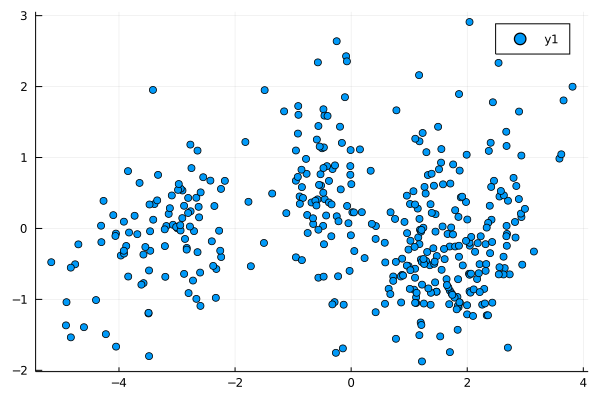

In [24]:
Plots.scatter(Yte[1, :], Yte[2, :])

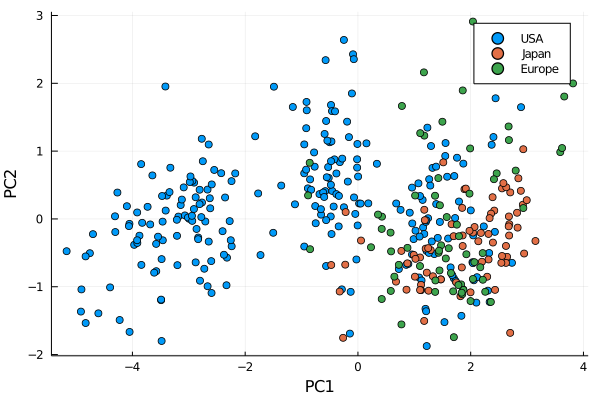

In [25]:
Plots.scatter(Yte[1, carorigin .== "USA"], 
              Yte[2, carorigin .== "USA"], 
              color=1, 
              label="USA")
Plots.scatter!(Yte[1, carorigin .== "Japan"], 
               Yte[2, carorigin .== "Japan"], 
               color=2, 
               label="Japan")
Plots.scatter!(Yte[1, carorigin .== "Europe"], 
               Yte[2, carorigin .== "Europe"], 
               color=3, 
               label="Europe")
Plots.xlabel!("PC1")
Plots.ylabel!("PC2")

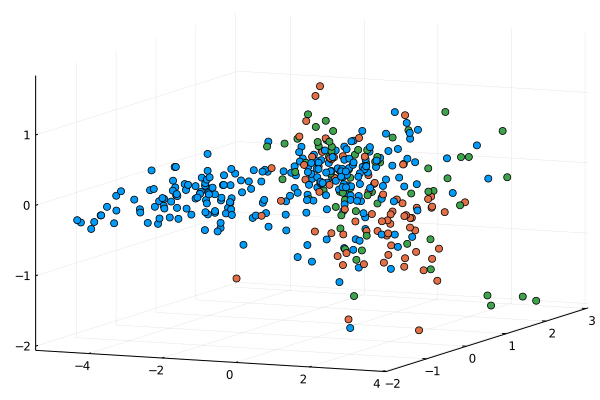

In [26]:
p = fit(PCA, data', maxoutdim=3)
Yte = MultivariateStats.transform(p, data')
scatter3d(Yte[1, :], Yte[2, :], Yte[3, :], color=uniqueids, legend=false)

In [30]:
#scene = Makie.scatter(Yte[1, :], Yte[2, :], Yte[3, :], color=uniqueids)

In [31]:
#display(scene)

### T-SNE

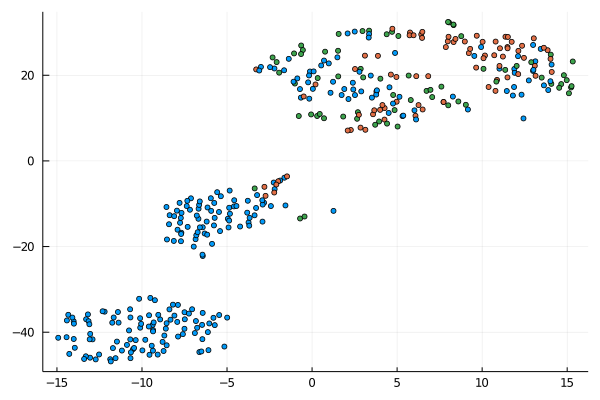

In [32]:
@sk_import manifold: TSNE
tfn = TSNE(n_components=2)
Y2 = tfn.fit_transform(data)
Plots.scatter(
    Y2[:, 1], Y2[:, 2], color=uniqueids, legend=false, markersize=3)

### UMAP

In [33]:
L = cor(data, data, dims=2)
embedding = umap(L, 2)

2×392 Array{Float64,2}:
 -6.62681  -7.24855  -6.48403  …  7.7214    5.28047  6.57681  6.94908
 -5.87287  -6.04158  -6.45446     3.17111  -2.55528  3.27913  3.06287

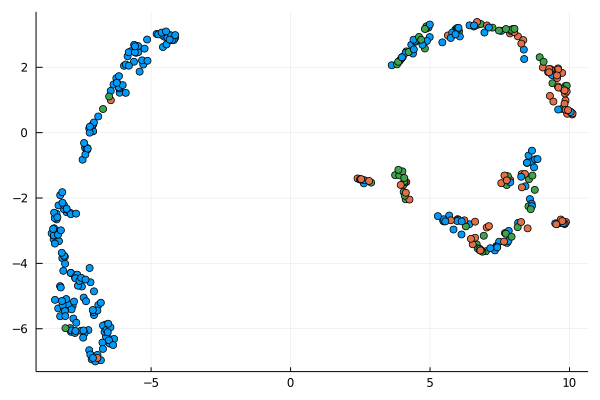

In [35]:
Plots.scatter(
    embedding[1, :], embedding[2, :], color=uniqueids, legend=false)

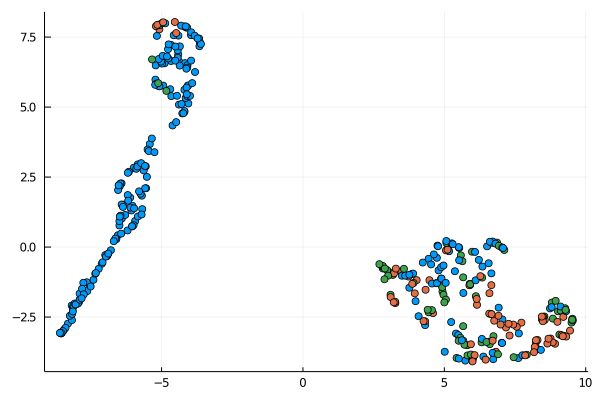

In [36]:
# Can use any dist metric
L = pairwise(Euclidean(), data, data, dims=1)
embedding = umap(L, 2)
Plots.scatter(
    embedding[1, :], embedding[2, :], color=uniqueids, legend=false)